<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif False:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

TF version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [2]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_probability as tfp
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz
from scipy.optimize import minimize_scalar

!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
import fontParts
import extractor
import defcon
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")

✓ Dependencies imported.


In [3]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [4]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "bdghijlmnopqu" # straight letters only
#glyph_char_list = "abgjqrst"
glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "abc"

# ==== Create Font ====
factor = 1.0 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 2
sample_distance_deltas = [-2, 0, 2]
sample_distance_factors = [.5, 1., 2.0]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 5
n_b_scales = 1
n_v1_orientations = 4
n_v4_scales = 8

Box size: 80 × 161


Spatial frequency scales: [ 0.7         1.32708333  3.20833333  6.34375    10.73333333]


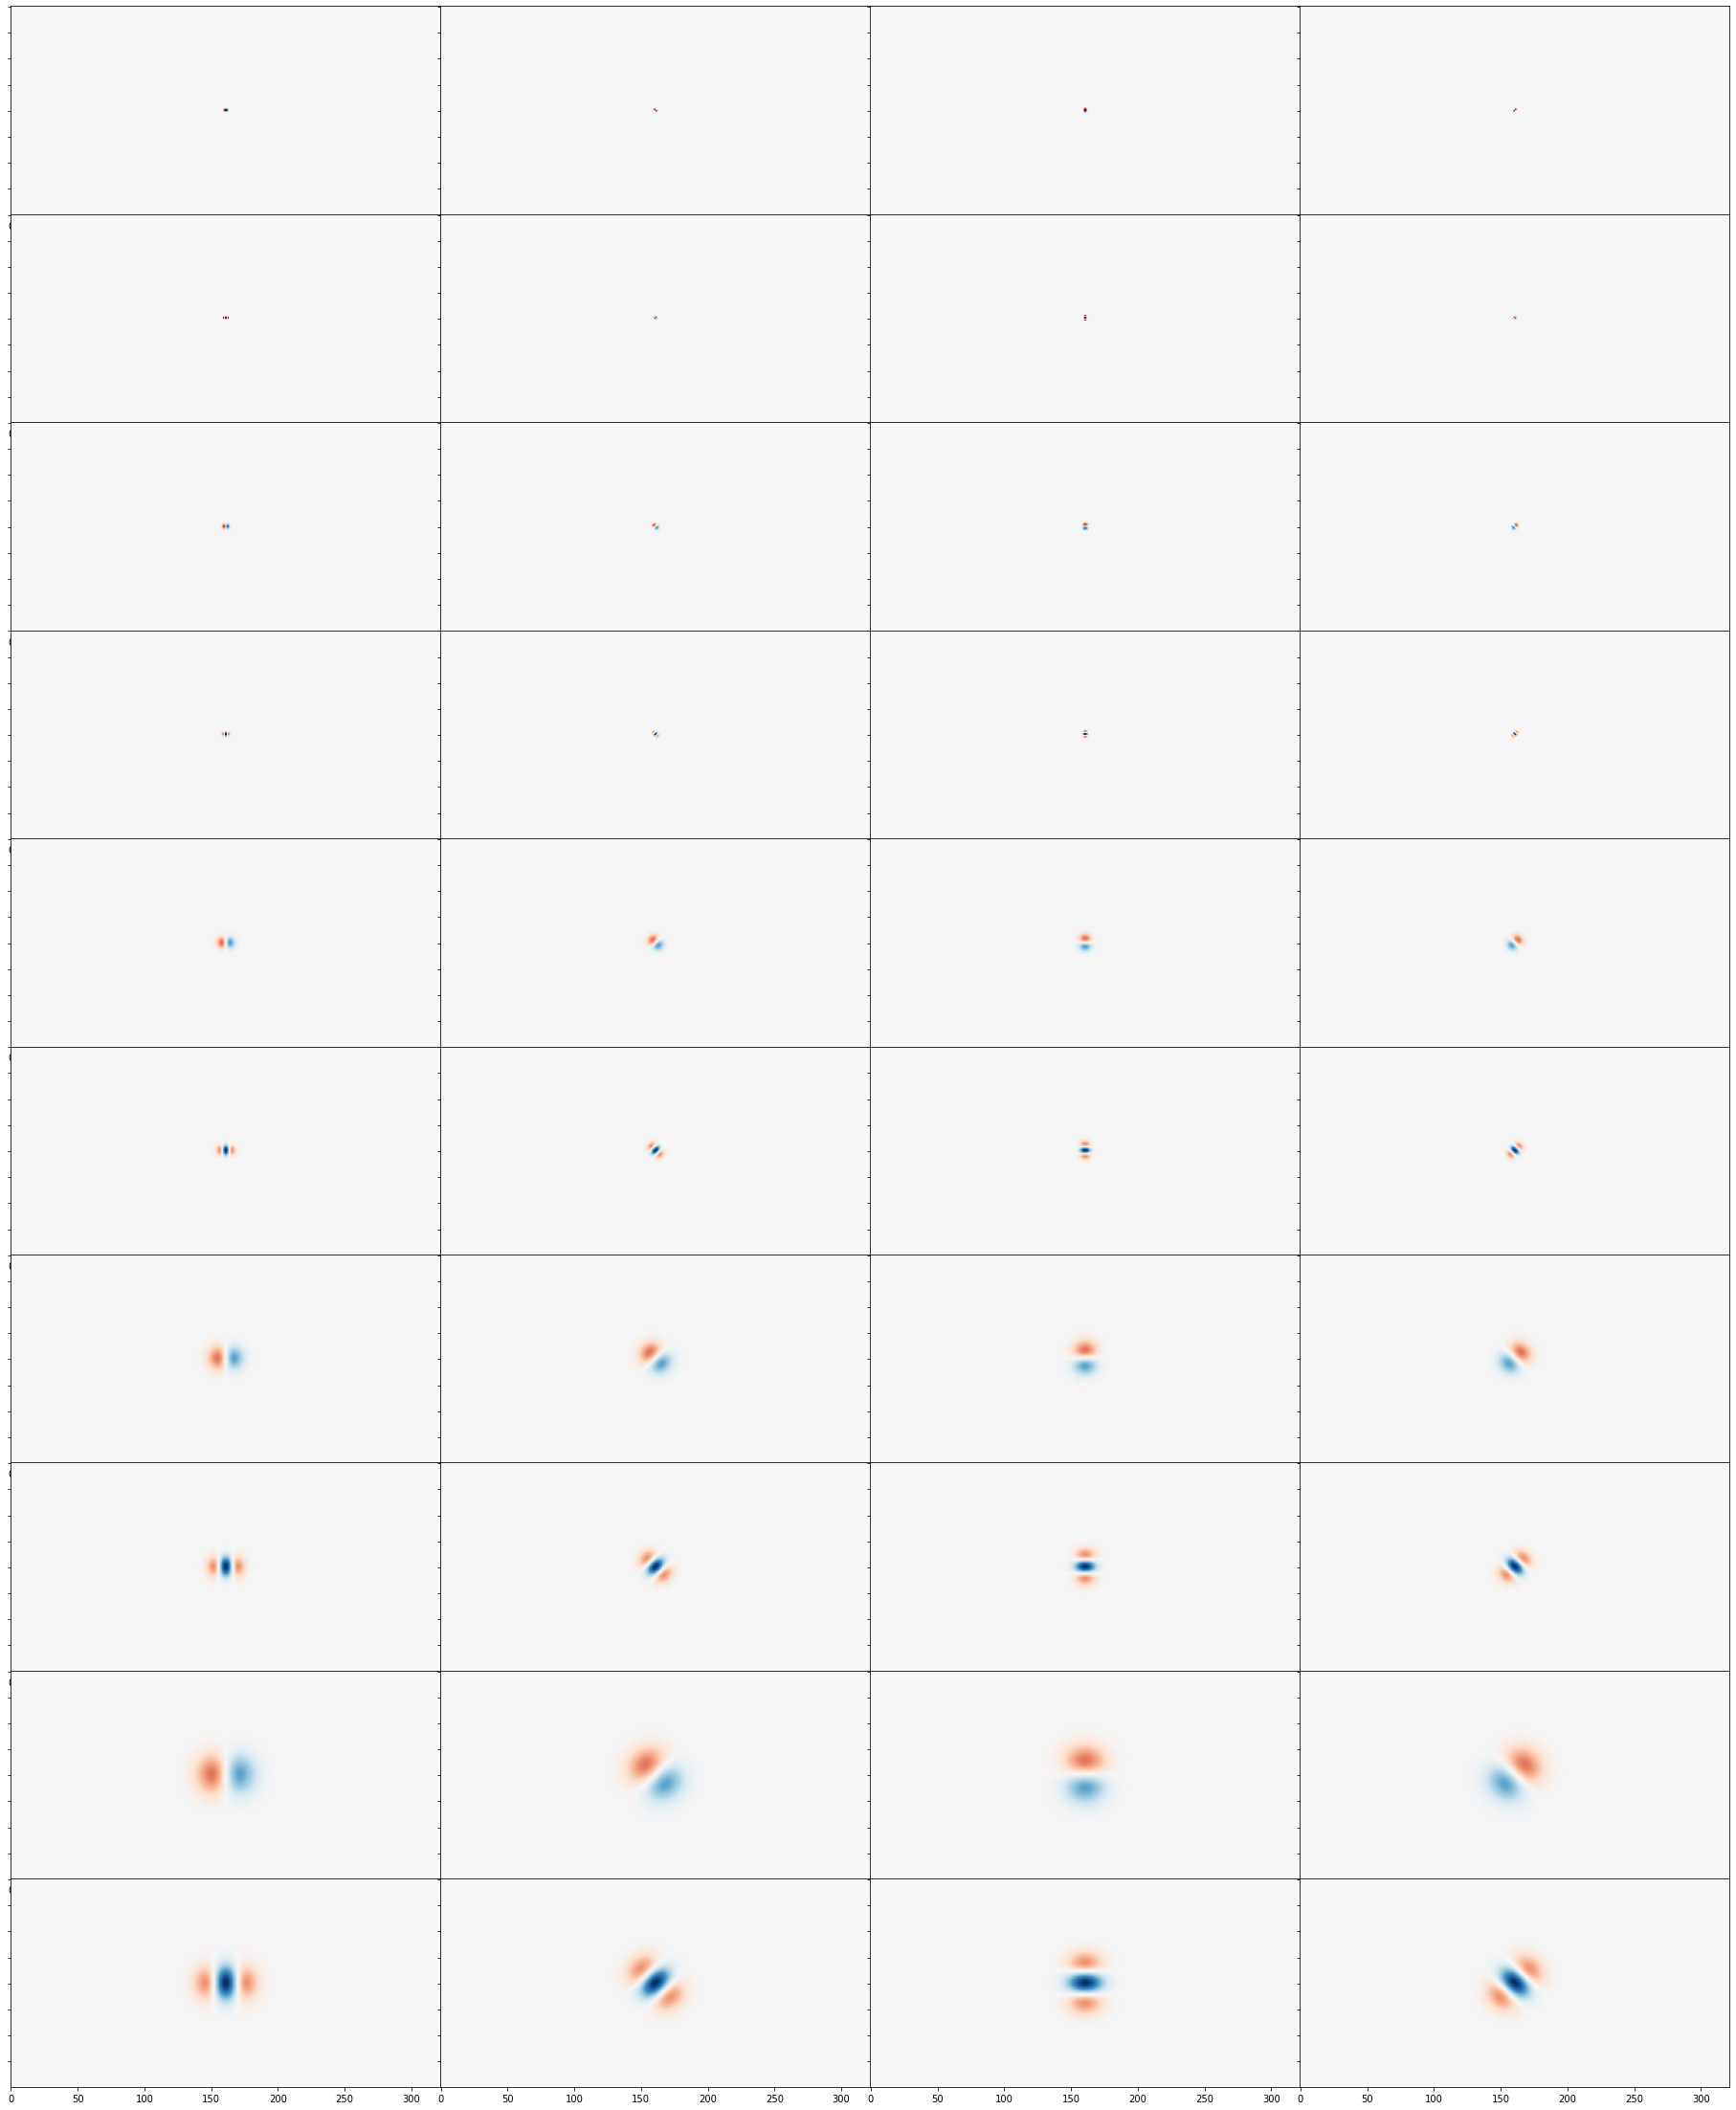

In [5]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        min_sigma = 0.7
        max_sigma = box_width / 15
        sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_v1_scales - 1)**2 + min_sigma)
        #sigmas.append((max_sigma - min_sigma) * s / n_v1_scales + min_sigma)
    return np.array(sigmas)

print("Spatial frequency scales:", get_sigmas())

def get_v1_filter_bank(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                             [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(s, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.

        # First derivative (odd filter/up-down)
        d1_space = np.exp(-(x**2+y**2)/(2*s**2))*x/(2*pi*s**4)
        d1_relu_sum = np.sum(d1_space * (d1_space > 0))
        d1 = np.fft.fft2(np.fft.ifftshift(d1_space + 1j * np.zeros_like(d1_space)))

        # Second derivative (even filter/mexican hat):
        s2 = s * .85 # To make them about the same width
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2_relu_sum = np.sum(d2_space * (d2_space > 0))
        d2 = (d1_relu_sum / d2_relu_sum) * np.fft.fft2(np.fft.ifftshift(d2_space + 1j * np.zeros_like(d2_space)))

        return (d1 + 1j*d2) / (np.max(tf.abs(d1+1j*d2))) # Max output should be about 0.2, which leaves lots of flexibility for the HRA later

    filter_bank = np.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 20
        fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter(sigma, o)
            if display_filters:
                mx = np.max(np.abs(np.imag(np.fft.ifft2(f))))
                ax[s*2, o].imshow(np.real(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()

    return filter_bank.astype(np.complex64)

filter_bank = get_v1_filter_bank(0, display_filters=True)


def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    bdsohw_input_image = input_image[None, None, None, None, :, :]

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(padded_input, tf.zeros_like(padded_input))))

    padded_result = tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :])

    presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], [2, 3])

    return presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

In [6]:
pf = 3

eps = np.finfo(np.float32).tiny
u, v = np.mgrid[-box_height*pf/2:box_height*pf/2,-box_width*pf/2:box_width*pf/2].astype(np.float32)
r = np.sqrt(u**2 + v**2)[None, None, :, :] / (box_height*pf/2)
r[r == 0] = 0.5
angle = np.arctan2(u, v)[None, None, :, :] # <b, d, s, o, c, h, w>
angles = np.arange(n_v1_orientations)[None, :, None, None].astype(np.float32)/n_v1_orientations
angle_mask_widths = 4. * np.ones((n_v1_scales, n_v1_orientations)).astype(np.float32)

def make_blur_filters(e): # Returns masks of shape <o, c, h, w>
    radial_mask = (1/(r + eps)) ** e
    distance_mask = (1/(r + eps)) ** (e+1)

    # Uses von-Mises distribution (via Bessel function)
    bp_angle_masks = tf.exp(-angle_mask_widths[:, :, None, None] * tf.cos(angle - pi - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths[:, :, None, None]))
    bn_angle_masks = tf.exp(-angle_mask_widths[:, :, None, None] * tf.cos(angle - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths[:, :, None, None]))

    x1 = tf.concat([radial_mask * bp_angle_masks, radial_mask * bn_angle_masks], axis=1)
    x2 = tf.concat([distance_mask * bp_angle_masks, distance_mask * bn_angle_masks], axis=1)

    return (x1, x2)

blur_e = 2.
(x1_filter, x2_filter) = make_blur_filters(blur_e)
x1_filter_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(x1_filter, 0.), [2,3]))
x2_filter_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(x2_filter, 0.), [2,3]))
print(x1_filter_fft.shape)

(5, 8, 240, 483)


100%|██████████| 26/26 [00:00<00:00, 985.77it/s]

  ✓ 26 glyphs rendered.



100%|██████████| 26/26 [00:00<00:00, 83245.73it/s]

  ✓ 26 glyphs measured.



100%|██████████| 26/26 [00:01<00:00, 16.87it/s]

  ✓ 26 glyphs filtered.



100%|██████████| 26/26 [00:00<00:00, 70.90it/s]

  ✓ 26 glyphs strengthed.


glyph (5, 8, 80, 161)
glyph (5, 4, 80, 161)
Scale: 0


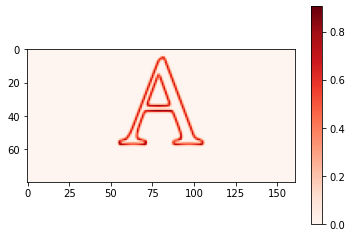

Scale: 1


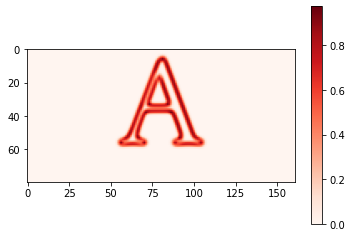

Scale: 2


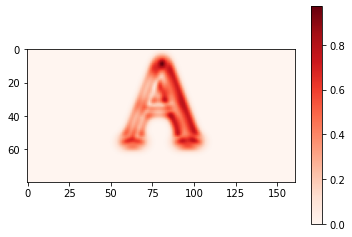

Scale: 3


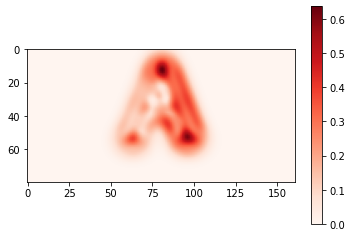

Scale: 4


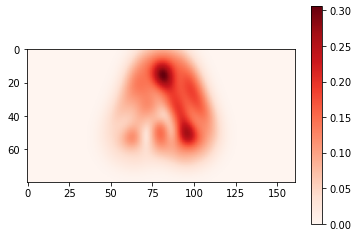

SCALE: 0


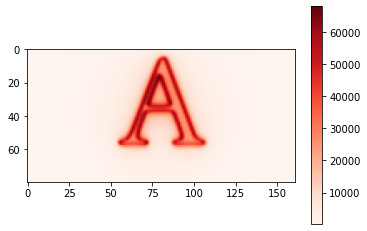

SCALE: 1


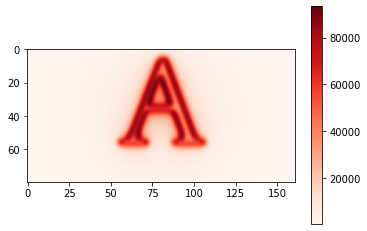

SCALE: 2


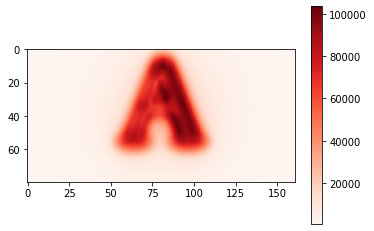

SCALE: 3


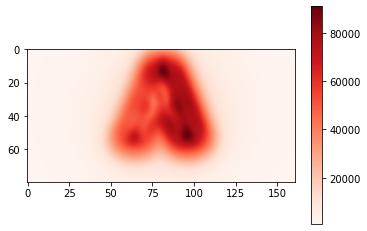

SCALE: 4


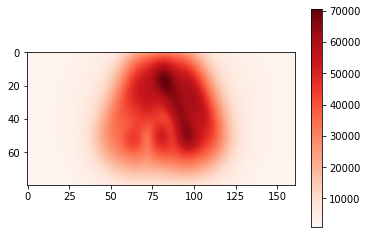

In [7]:
# 1. Render glyphs

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

def get_v1_response(glyph_image):
    """Returns a np.array of shape [n_v1_scales, n_v1_orientations, box_height, box_width] and type complex64,
    containing the local responses to the V1 filter bank (after inverse Fourier transform, i.e. in the spatial domain)."""
    with tf.device("/gpu:0"):
        filtered = apply_filter_bank(glyph_image, filter_bank)
    return filtered

def get_v4_strength(glyph_v1_response):
    """Returns a np.array of shape [n_v1_scales, 2*n_v1_orientations, box_height, box_width]."""
    with tf.device("/gpu:0"):
        # Pad the image, fft convolve it, 
        padded_image = tf.pad(tf.abs(glyph_v1_response), [[0, 0], [0, 0], [int((pf-1)*box_height/2), int((pf-1)*box_height/2)],
                                                                  [int((pf-1)*box_width/2), int((pf-1)*box_width/2)]])
        padded_image_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(tf.concat(2*[padded_image], axis=1), 0.), [2, 3]))
        x1_full = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(padded_image_fft * x1_filter_fft), [2, 3]))
        x2_full = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(padded_image_fft * x2_filter_fft), [2, 3]))

        x1 = x1_full[:, :, int(np.ceil(box_height * (pf-1) / 2)):int(box_height + np.ceil(box_height * (pf-1)/ 2)),
                        int(np.ceil(box_width  * (pf-1)/ 2)):int(box_width + np.ceil(box_width * (pf-1)/ 2))]
        x2 = x2_full[:, :, int(np.ceil(box_height * (pf-1) / 2)):int(box_height + np.ceil(box_height * (pf-1)/ 2)),
                        int(np.ceil(box_width  * (pf-1)/ 2)):int(box_width + np.ceil(box_width * (pf-1)/ 2))]

        distances = x1 / x2
        fullnesses = x1 * distances ** (blur_e - 1)
        strengths = fullnesses / distances
        return strengths


glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)
glyph_v1_responses = {c: get_v1_response(glyph_images[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs filtered.", flush=True)
glyph_v4_strengths = {c: get_v4_strength(glyph_v1_responses[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs strengthed.", flush=True)
print("glyph", glyph_v4_strengths[glyph_char_list[0]].shape)
print("glyph", glyph_v1_responses[glyph_char_list[0]].shape)

# 1a. Show an example of filtered glyphs
for si in range(n_v1_scales):
    print("Scale:", si)
    #plt.imshow(glyph_images["b"], cmap="gray")
    plt.imshow(np.sum(np.abs(glyph_v1_responses[glyph_char_list[0]][si, :, :, :]), (0))**2, cmap="Reds", alpha=1.0)
    plt.colorbar()
    plt.show()

# 1b. Show an example of filtered glyphs
for si in range(n_v1_scales):
    print("SCALE:", si)
    #plt.imshow(glyph_images["b"], cmap="gray")
    plt.imshow(tf.reduce_sum(glyph_v4_strengths[glyph_char_list[0]][si, :, :, :], [0]), cmap="Reds", alpha=1.0)
    plt.colorbar()
    plt.show()

#plt.imshow(glyph_images["a"], cmap="gray")
#plt.show()



In [8]:
# 2. Assemble pairs

def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)
    
left_images = []
right_images = []
left_v1_responses = []
right_v1_responses = []
left_v4_strengths = []
right_v4_strengths = []
left_translations = []
right_translations = []

for c1 in tqdm(glyph_char_list):
    for c2 in reversed(glyph_char_list):
        left_images.append(glyph_images[c1])
        right_images.append(glyph_images[c2])
        left_v1_responses.append(glyph_v1_responses[c1])
        right_v1_responses.append(glyph_v1_responses[c2])
        left_v4_strengths.append(glyph_v4_strengths[c1])
        right_v4_strengths.append(glyph_v4_strengths[c2])

        lt, rt = get_pair_translations(c1, c2, None, sample_distance_factors) #sample_distance_deltas
        left_translations.append(lt)
        right_translations.append(rt)

print("  ✓", len(glyph_char_list)**2, "pairs assembled.")

# 3. Set up generator to yield pairs, and wrap generator in a tf.Dataset

def return_pair():
    i = 0
    while i < len(left_images):
        yield {
            "left_image": left_images[i],
            "right_image": right_images[i],
            "left_v1_response": left_v1_responses[i],
            "right_v1_response": right_v1_responses[i],
            "left_v4_strength": left_v4_strengths[i],
            "right_v4_strength": right_v4_strengths[i],
            "left_translations": left_translations[i],
            "right_translations": right_translations[i],
        }
        i = (i + 1) % len(left_images)

dataset = tf.data.Dataset.from_generator(
     return_pair,
     {
      "left_image": tf.float32,
      "right_image": tf.float32,
      "left_v1_response": tf.complex64,
      "right_v1_response": tf.complex64,
      "left_v4_strength": tf.float32,
      "right_v4_strength": tf.float32,
      "left_translations": tf.int32,
      "right_translations": tf.int32,
     },
     {
      "left_image": tf.TensorShape([box_height, box_width]),
      "right_image": tf.TensorShape([box_height, box_width]),
      "left_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "right_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "left_v4_strength": tf.TensorShape([n_v1_scales, 2*n_v1_orientations, box_height, box_width]),
      "right_v4_strength": tf.TensorShape([n_v1_scales, 2*n_v1_orientations, box_height, box_width]),
      "left_translations": tf.TensorShape([n_sample_distances,]),
      "right_translations": tf.TensorShape([n_sample_distances,])
     },
)

print("\n  ✓ Dataset ready.")

100%|██████████| 26/26 [00:00<00:00, 149.38it/s]


  ✓ 676 pairs assembled.

  ✓ Dataset ready.


In [9]:
# 4. Apply horizontal translations in the dataset

def translate_4d_image(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, height, width>
    """

    images = tf.tile(input_image[:, :, :, :, None], [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_image.shape[3]] # positive shift: left-shift

    result = tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype)

    # Manually ensure that the width-dimension hasn't changed
    s = list(result.shape)
    s[-1] = box_width
    result.set_shape(s)

    return result

def apply_translations(d):
    d["left_image"] = translate_4d_image(d["left_image"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_image"] = translate_4d_image(d["right_image"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v1_response"] = translate_4d_image(d["left_v1_response"], d["left_translations"])
    d["right_v1_response"] = translate_4d_image(d["right_v1_response"], d["right_translations"])
    d["left_v4_strength"] = translate_4d_image(d["left_v4_strength"], d["left_translations"])
    d["right_v4_strength"] = translate_4d_image(d["right_v4_strength"], d["right_translations"])
    del d["left_translations"]
    del d["right_translations"]
    return (d, 0.)  # The zero here doesn't do anything and is just to make Keras happy, because model.fit expects a dataset of 2-tuples where the second entry is the target value.

translated_dataset = dataset.map(apply_translations)

print("dataset shapes:", translated_dataset.element_spec)

Instructions for updating:
Use fn_output_signature instead
dataset shapes: ({'left_image': TensorSpec(shape=(3, 80, 161), dtype=tf.float32, name=None), 'right_image': TensorSpec(shape=(3, 80, 161), dtype=tf.float32, name=None), 'left_v1_response': TensorSpec(shape=(3, 5, 4, 80, 161), dtype=tf.complex64, name=None), 'right_v1_response': TensorSpec(shape=(3, 5, 4, 80, 161), dtype=tf.complex64, name=None), 'left_v4_strength': TensorSpec(shape=(3, 5, 8, 80, 161), dtype=tf.float32, name=None), 'right_v4_strength': TensorSpec(shape=(3, 5, 8, 80, 161), dtype=tf.float32, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))


IN: (None, 3, 5, 8, 80, 161) (None, 3, 5, 8, 80, 161)
ORIGINAL STRENGTH Tensor("left_v4_strength_1:0", shape=(None, 3, 5, 8, 80, 161), dtype=float32)
Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 107.4659Skeleton losses:
SUM IS [[301.32596 233.34726 141.31549]
 [301.5985  256.2689  181.24103]]


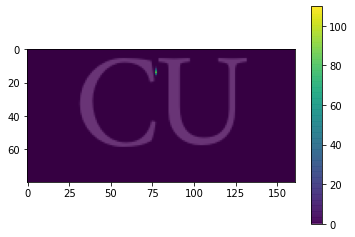

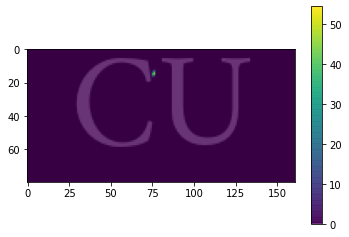

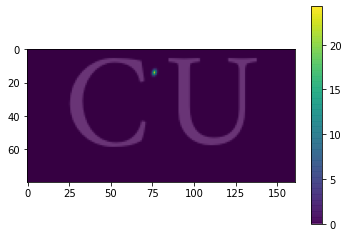

Grouping strength layer:
exponents:


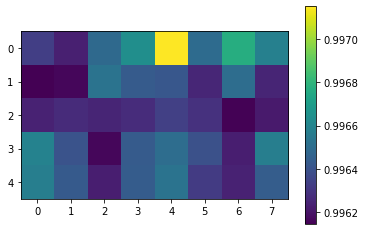

coefficients:


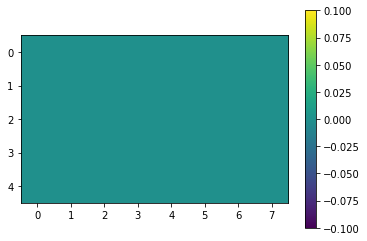

Blurwidth: 0.49615917
Skeleton loss softmax n: -0.0014874146
20/20 [==============================] - 7s 359ms/step - loss: 107.4659
Epoch 2/1000
20/20 [==============================] - 2s 116ms/step - loss: 109.3861
Epoch 3/1000
20/20 [==============================] - 2s 119ms/step - loss: 96.7490
Epoch 4/1000
20/20 [==============================] - 2s 124ms/step - loss: 93.7774
Epoch 5/1000
20/20 [==============================] - 2s 120ms/step - loss: 78.3494
Epoch 6/1000
20/20 [==============================] - 2s 124ms/step - loss: 57.8849
Epoch 7/1000
20/20 [==============================] - 2s 125ms/step - loss: 63.2079
Epoch 8/1000
20/20 [==============================] - 2s 122ms/step - loss: 59.7224
Epoch 9/1000
20/20 [==============================] - 2s 124ms/step - loss: 69.7109
Epoch 10/1000
20/20 [==============================] - 2s 123ms/step - loss: 68.7211
Epoch 11/1000
20/20 [==============================] - 2s 124ms/step - loss: 63.8246
Epoch 12/1000
20/20 [===

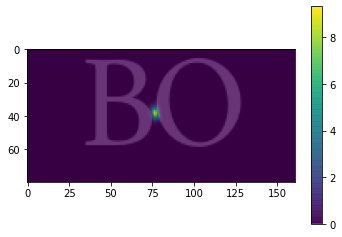

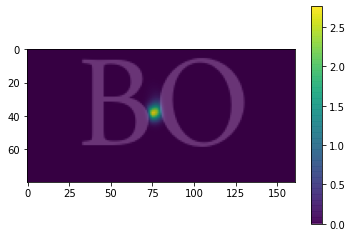

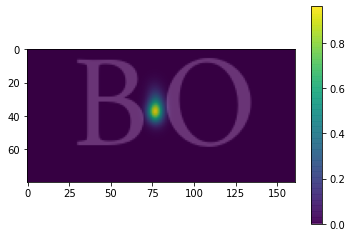

Grouping strength layer:
exponents:


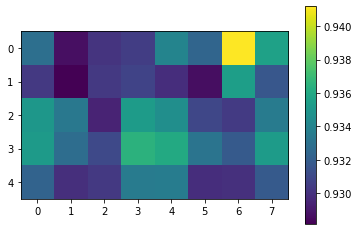

coefficients:


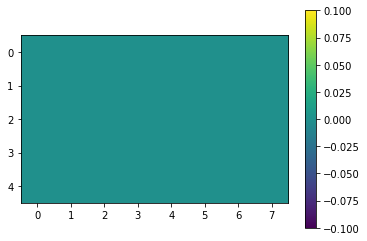

Blurwidth: 0.42496988
Skeleton loss softmax n: -0.100407556
20/20 [==============================] - 4s 182ms/step - loss: 20.0730
Epoch 24/1000
20/20 [==============================] - 2s 118ms/step - loss: 14.5327
Epoch 25/1000
20/20 [==============================] - 3s 126ms/step - loss: 6.6601
Epoch 26/1000
20/20 [==============================] - 2s 124ms/step - loss: 0.0243
Epoch 27/1000
20/20 [==============================] - 2s 124ms/step - loss: -6.8168
Epoch 28/1000
20/20 [==============================] - 2s 122ms/step - loss: -4.0347
Epoch 29/1000
20/20 [==============================] - 2s 125ms/step - loss: -1.4023
Epoch 30/1000
20/20 [==============================] - 2s 123ms/step - loss: -0.9023
Epoch 31/1000
20/20 [==============================] - 2s 122ms/step - loss: -1.8124
Epoch 32/1000
20/20 [==============================] - 2s 123ms/step - loss: -5.3736
Epoch 33/1000
20/20 [==============================] - 2s 121ms/step - loss: -2.2995
Epoch 34/1000
20/20 [

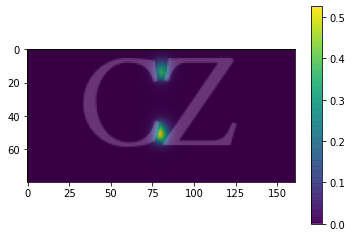

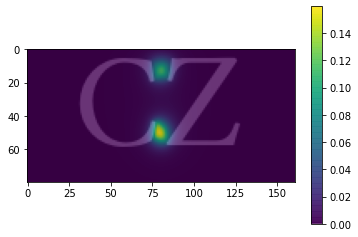

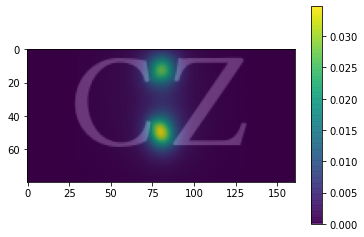

Grouping strength layer:
exponents:


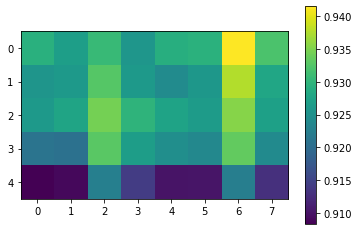

coefficients:


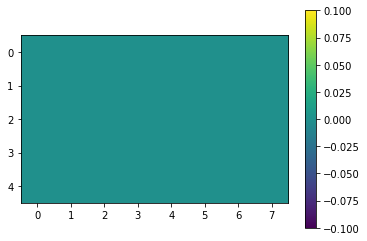

Blurwidth: 0.4117892
Skeleton loss softmax n: -0.13940328
20/20 [==============================] - 4s 184ms/step - loss: -5.7828
Epoch 46/1000
20/20 [==============================] - 2s 117ms/step - loss: -5.2356
Epoch 47/1000
20/20 [==============================] - 2s 119ms/step - loss: -1.9383
Epoch 48/1000
20/20 [==============================] - 2s 123ms/step - loss: -2.3401
Epoch 49/1000
20/20 [==============================] - 2s 122ms/step - loss: -4.4504
Epoch 50/1000
20/20 [==============================] - 2s 121ms/step - loss: -6.0994
Epoch 51/1000
20/20 [==============================] - 2s 122ms/step - loss: -3.6518
Epoch 52/1000
20/20 [==============================] - 3s 126ms/step - loss: -0.9266
Epoch 53/1000
20/20 [==============================] - 2s 123ms/step - loss: -3.5397
Epoch 54/1000
20/20 [==============================] - 2s 121ms/step - loss: -4.0399
Epoch 55/1000
20/20 [==============================] - 2s 122ms/step - loss: -7.6158
Epoch 56/1000
20/20 [

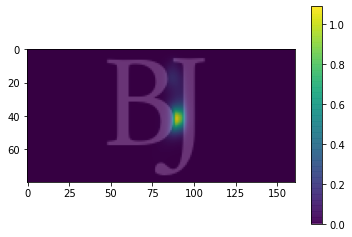

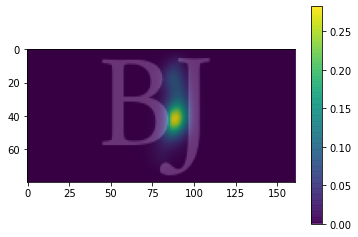

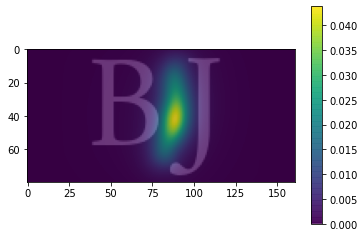

Grouping strength layer:
exponents:


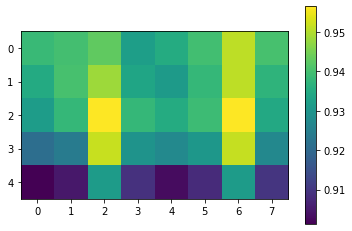

coefficients:


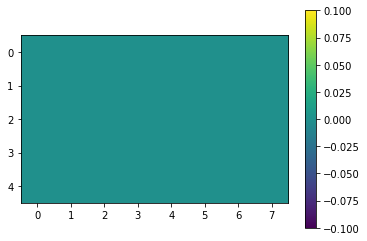

Blurwidth: 0.41592476
Skeleton loss softmax n: -0.13254133
20/20 [==============================] - 4s 183ms/step - loss: -1.4867
Epoch 68/1000
20/20 [==============================] - 2s 115ms/step - loss: -5.6331
Epoch 69/1000
20/20 [==============================] - 2s 123ms/step - loss: -4.0826
Epoch 70/1000
20/20 [==============================] - 2s 120ms/step - loss: -6.0646
Epoch 71/1000
20/20 [==============================] - 2s 122ms/step - loss: -6.9046
Epoch 72/1000
20/20 [==============================] - 2s 121ms/step - loss: -6.3174
Epoch 73/1000
20/20 [==============================] - 2s 123ms/step - loss: -5.3927
Epoch 74/1000
20/20 [==============================] - 2s 121ms/step - loss: -8.5852
Epoch 75/1000
20/20 [==============================] - 2s 123ms/step - loss: -4.6959
Epoch 76/1000
20/20 [==============================] - 2s 123ms/step - loss: -6.5932
Epoch 77/1000
20/20 [==============================] - 2s 124ms/step - loss: -6.4736
Epoch 78/1000
20/20 

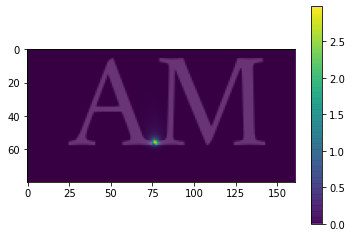

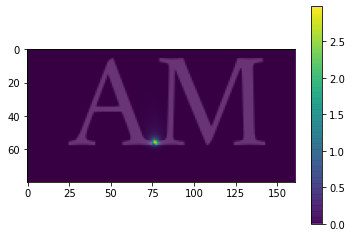

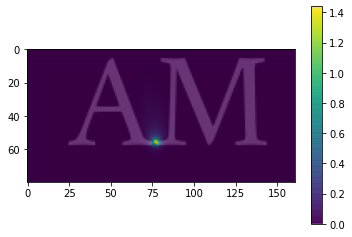

Grouping strength layer:
exponents:


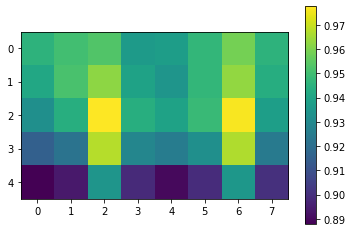

coefficients:


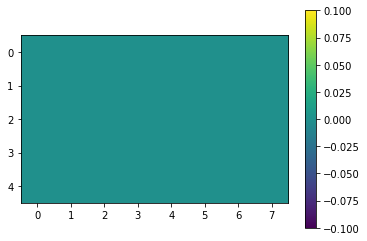

Blurwidth: 0.41509485
Skeleton loss softmax n: -0.13202746
20/20 [==============================] - 4s 193ms/step - loss: -8.9489
Epoch 90/1000
20/20 [==============================] - 2s 114ms/step - loss: -8.7020
Epoch 91/1000
20/20 [==============================] - 2s 121ms/step - loss: -6.3966
Epoch 92/1000
20/20 [==============================] - 2s 123ms/step - loss: -7.7135
Epoch 93/1000
20/20 [==============================] - 2s 121ms/step - loss: -7.8491
Epoch 94/1000
20/20 [==============================] - 2s 119ms/step - loss: -5.9067
Epoch 95/1000
20/20 [==============================] - 2s 121ms/step - loss: -6.2012
Epoch 96/1000
20/20 [==============================] - 2s 122ms/step - loss: -7.0210
Epoch 97/1000
20/20 [==============================] - 2s 122ms/step - loss: -6.6895
Epoch 98/1000
20/20 [==============================] - 2s 124ms/step - loss: 0.3510
Epoch 99/1000
20/20 [==============================] - 2s 124ms/step - loss: -2.9176
Epoch 100/1000
20/20 

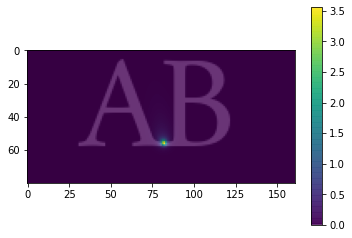

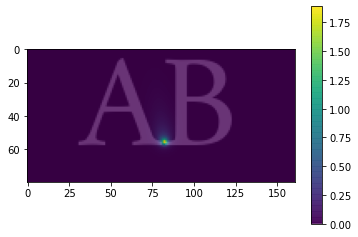

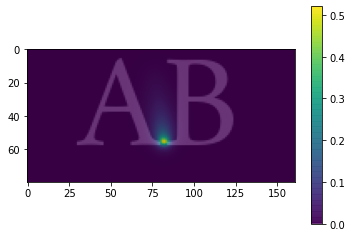

Grouping strength layer:
exponents:


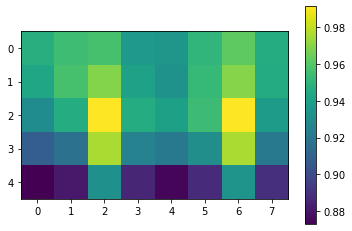

coefficients:


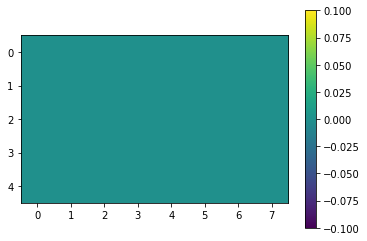

Blurwidth: 0.41093406
Skeleton loss softmax n: -0.13605094
20/20 [==============================] - 4s 188ms/step - loss: -8.6160
Epoch 112/1000
20/20 [==============================] - 2s 115ms/step - loss: -5.6229
Epoch 113/1000
20/20 [==============================] - 2s 122ms/step - loss: -6.2706
Epoch 114/1000
20/20 [==============================] - 2s 121ms/step - loss: -2.9406
Epoch 115/1000
20/20 [==============================] - 2s 122ms/step - loss: -4.7908
Epoch 116/1000
20/20 [==============================] - 2s 122ms/step - loss: -5.2677
Epoch 117/1000
20/20 [==============================] - 2s 120ms/step - loss: -4.5035
Epoch 118/1000
20/20 [==============================] - 2s 121ms/step - loss: -6.8332
Epoch 119/1000
20/20 [==============================] - 2s 120ms/step - loss: -5.9253
Epoch 120/1000
20/20 [==============================] - 2s 123ms/step - loss: -2.8888
Epoch 121/1000
20/20 [==============================] - 2s 121ms/step - loss: -8.8415
Epoch 122/

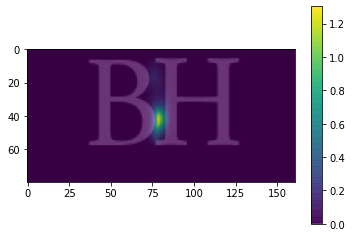

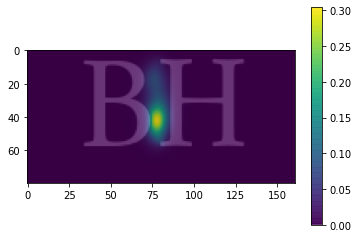

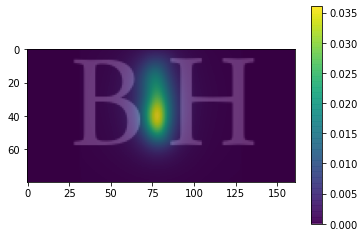

Grouping strength layer:
exponents:


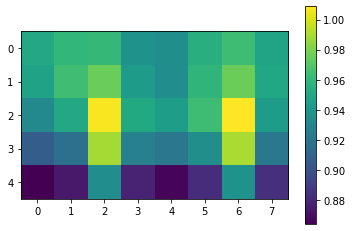

coefficients:


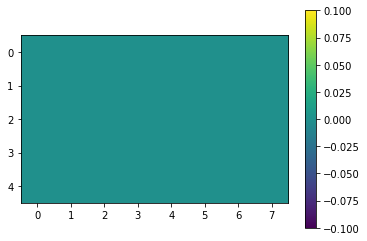

Blurwidth: 0.41191736
Skeleton loss softmax n: -0.13367893
20/20 [==============================] - 4s 187ms/step - loss: -0.4195
Epoch 134/1000
20/20 [==============================] - 2s 119ms/step - loss: -4.7918
Epoch 135/1000
20/20 [==============================] - 2s 123ms/step - loss: -6.4560
Epoch 136/1000
20/20 [==============================] - 2s 121ms/step - loss: -5.5523
Epoch 137/1000
20/20 [==============================] - 2s 120ms/step - loss: -7.4890
Epoch 138/1000
20/20 [==============================] - 2s 121ms/step - loss: -11.9802
Epoch 139/1000
20/20 [==============================] - 2s 121ms/step - loss: -10.5814
Epoch 140/1000
20/20 [==============================] - 2s 120ms/step - loss: -8.3887
Epoch 141/1000
20/20 [==============================] - 2s 124ms/step - loss: -5.1861
Epoch 142/1000
20/20 [==============================] - 3s 125ms/step - loss: -7.7908
Epoch 143/1000
20/20 [==============================] - 3s 126ms/step - loss: -2.3701
Epoch 14

In [ ]:
# 5. Utility functions
eps = np.finfo(np.float32).tiny

def invspa(t):
    return np.log(np.exp(t) - 1).astype(np.float32)

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

# 6. Generating G-cell fragments

u, v = np.mgrid[-box_height/2:box_height/2,-box_width/2:box_width/2].astype(np.float32)
u = u / (box_width)
v = v / (box_width)
r = np.sqrt(u**2 + v**2)[None, None, None, None, :, :]

def make_losses_filters(g_spreads):
    return tf.exp(-r**2 / (2*g_spreads**2)) / (g_spreads * tf.math.sqrt(2.*3.14159276))

class GroupingStrengthLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(GroupingStrengthLayer, self).__init__(**kwargs)
        # Todo: we can try adding height here
        self.exponents = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="exponents",
                                 trainable=True)  
        self.coefficients = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="coefficients",
                                 trainable=True)  

    def print_weights(self):
        print("exponents:")
        plt.imshow(tf.nn.relu(self.exponents))
        plt.colorbar()
        plt.show()
        print("coefficients:")
        plt.imshow(tf.nn.relu(self.coefficients) / (eps + tf.reduce_mean(tf.nn.relu(self.coefficients))))
        plt.colorbar()
        plt.show()

    def call(self, inputs):
        i = eps + tf.nn.relu(inputs)
        c = (eps + tf.nn.relu(self.coefficients))[None, None, :, :, None, None] / (eps + tf.reduce_mean(tf.nn.relu(self.coefficients)))
        e = (eps + tf.nn.relu(self.exponents))[None, None, :, :, None, None]

        return tf.reduce_sum((c * i) ** e, [2, 3], keepdims=True)


# 8. Cost layer
class SkeletonCostLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(SkeletonCostLayer, self).__init__(**kwargs)
        # <b, s, o, h, w, d>

        self.blurwidth = self.add_weight(shape=(),
                                 initializer=tf.keras.initializers.Constant(.5),
                                 name="blurwidths",
                                 trainable=True)  

        self.n = self.add_weight(shape=(),
                                 initializer=tf.keras.initializers.Constant(0.),
                                 name="n",
                                 trainable=True)  

    def print_weights(self):
        print("Blurwidth:", self.blurwidth.numpy())
        print("Skeleton loss softmax n:", self.n.numpy())

    def call(self, inputs):
        #(l, r, p) = inputs

        # Find the skeleton losses
        #losses = tf.nn.relu(l - p) + tf.nn.relu(r - p)

        losses = inputs / (50000 * 2)

        losses_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses, eps), [4, 5]))
        losses_filters = make_losses_filters(eps + tf.nn.relu(self.blurwidth) / 100.)
        losses_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses_filters, eps), [4, 5]))
        losses_filtered = (eps + tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(losses_fft * losses_filters_fft), [4, 5]))))

        #penalties = (tf.nn.relu(self.wk + eps) ** tf.range(n_v4_scales, dtype=tf.float32))[None, None, :, None, None]
        #penalties = tf.nn.relu(self.wp)[None, None, :, None, None]

        # Penalize the skeleton losses
        penalized_losses = losses_filtered #* penalties 

        # Find the worst penalty
        pln = penalized_losses * 10 ** (self.n * 10)
        expd = tf.exp(pln - tf.reduce_max(pln, [2,3,4,5], keepdims=True))
        softmax_weights = expd / (eps + tf.reduce_sum(expd, axis=[2,3,4,5], keepdims=True))
        worst_skeleton_loss_penalty = penalized_losses * softmax_weights

        return worst_skeleton_loss_penalty


# 9. Set up the actual math

def get_pair_violation_from_strength(left_v4_strength, right_v4_strength):
    # TODO: Give them each an exponent, weigh them by orientation and by scale, and sum them up.
    print("ORIGINAL STRENGTH", left_v4_strength)

    gsl = GroupingStrengthLayer()
    left_strength = gsl(left_v4_strength)
    right_strength = gsl(right_v4_strength)

    total_strength_loss = tf.identity(left_strength * right_strength / (left_strength + right_strength), "strengthloss")

    sll = SkeletonCostLayer()
    skeleton_loss_cost_image = tf.identity(sll(total_strength_loss), "skeleton_loss_cost_image") # <b, d>
    #skeleton_loss_cost_image = tf.reduce_sum(total_strength_loss, [2,3], name="skeleton_loss_cost_image")

    skeleton_loss_cost = tf.reduce_sum(skeleton_loss_cost_image, [2,3,4,5])

    ys = (skeleton_loss_cost - 66.) ** 2 / (eps + tf.reduce_mean(skeleton_loss_cost)) #+ (grouping_strength - self.target_grouping) ** 2 + 

    # Find worst violation of the well
    up_first_ness = (ys[:, 1] - ys[:, 0]) #[1,2,3,4,5,6]
    down_second_ness = (ys[:, 1] - ys[:, 2]) # has shape <batch_size>, [2,3,4,5,6,7,]
    worst_violation_sum = tf.reduce_mean((tf.reduce_max(tf.stack([up_first_ness, down_second_ness], axis=0), axis=[0]) + eps), name="worst_violation")
    return worst_violation_sum 

# 10. Set up Keras model and run

def get_keras_model():
    # The translated raw images aren't used in the model, they're just for visualization purposes ...
    left_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_image')
    right_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_image')

    # ... but the translated V1 responses are:
    left_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='left_v1_response', dtype=tf.complex64)
    right_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='right_v1_response', dtype=tf.complex64)
    left_v4_strength = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, 2*n_v1_orientations, box_height, box_width), name='left_v4_strength')
    right_v4_strength = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, 2*n_v1_orientations, box_height, box_width), name='right_v4_strength')

    lvs = tf.identity(left_v4_strength, "lvs")
    print("IN:", left_v4_strength.shape, lvs.shape)

    # This calls the V4 layer, the penalty/reward layer, and finds the max cost
    #total_violation = tf.identity(get_pair_violation(left_v1_response, right_v1_response), "total_violation")
    total_violation = tf.identity(get_pair_violation_from_strength(left_v4_strength, right_v4_strength), "total_violation") + 0. * tf.reduce_sum(lvs)

    return tf.keras.Model(inputs=[left_image, right_image, left_v4_strength, right_v4_strength, left_v1_response, right_v1_response], outputs=(total_violation))

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, interval):
        self.dataset = dataset
        self.interval = interval
        self.current_data = None

    def get_val(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])([self.current_data["left_v1_response"],
                                                                           self.current_data["right_v1_response"],
                                                                           self.current_data["left_v4_strength"],
                                                                           self.current_data["right_v4_strength"],
                                                                           self.current_data["left_image"],
                                                                           self.current_data["right_image"]])[0]
        return output

    def get_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        l.print_weights()

    def on_epoch_end(self, epoch, logs=None):
        # Only show this stuff every [interval] batches
        if epoch % self.interval != 0:
            return

        #print([l.name for l in self.model.layers])
        #print(self.model.inputs)

        self.current_data, _ = next(self.dataset) #list(self.dataset.take(1).as_numpy_iterator())[0]
        pair_images = self.current_data["left_image"] + self.current_data["right_image"]

        #print("\nPair DIFFS:")
        #pair_cost = self.get_val("pair_pixel_cost")
        #print("Pair total cost", self.get_val("pair_total_cost")[0, 0])
        #plt.imshow(pair_images[0, 0, :, :], alpha=1)
        #plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 0, 0, 0, 0, :, :], alpha=0.7)
        #plt.colorbar()
        #plt.show()
        #print("Pair total cost", self.get_val("pair_total_cost")[0, 1])
        #pair_cost = self.get_val("pair_pixel_cost")
        #plt.imshow(pair_images[0, 1, :, :], alpha=1)
        #plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 1, 0, 0, 0, :, :], alpha=0.7)
        #plt.colorbar()
        #plt.show()
        #print("Pair total cost", self.get_val("pair_total_cost")[0, 2])
        #pair_cost = self.get_val("pair_pixel_cost")
        #plt.imshow(pair_images[0, 2, :, :], alpha=1)
        #plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 2, 0, 0, 0, :, :], alpha=0.7)
        #plt.colorbar()
        #plt.show()

        # print("Grouping strengths:")
        # local_grouping_strengths = self.get_val("grouping_local_strengths")
        # for nb in range(n_sample_distances):
        #     plt.imshow(pair_images[0, nb, :, :], cmap="gray")
        #     plt.imshow(tf.reduce_sum(local_grouping_strengths[0, nb, :, :, :], [0]), alpha=.8)
        #     plt.colorbar()
        #     plt.show()

        print("Skeleton losses:")
        local_skeleton_loss_cost = self.get_val("skeleton_loss_cost_image")


        print("SUM IS", tf.reduce_sum(local_skeleton_loss_cost[:, :, :, :, :, :], [2,3,4,5]).numpy())

        for nb in range(n_sample_distances):
            plt.imshow(pair_images[0, nb, :, :], cmap="gray")
            #plt.imshow(tf.reduce_sum(local_skeleton_loss_cost[0, nb, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
            #                  int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], [0]), alpha=.8)
            plt.imshow(tf.reduce_sum(local_skeleton_loss_cost[0, nb, :, :, :, :], [0, 1]), alpha=.8)
            plt.colorbar()
            plt.show()

        print("Grouping strength layer:")
        self.print_weights("grouping_strength_layer")
        self.print_weights("skeleton_cost_layer")

        return

        pair_diff = self.get_val("relevance")
        maxv = tf.reduce_max(pair_diff)
        minv = tf.reduce_min(pair_diff)
        ex = max(abs(maxv), abs(minv))
        fs = 16

        left_v4_response = self.get_val("left_v4_response")
        right_v4_response = self.get_val("right_v4_response")
        pair_v4_response = self.get_val("pair_v4_response")
        if True: # False if displaying B cells
            print("RAW LOSSES for size")
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 1, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(pair_diff[0, 1, 0, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            plt.show()
    
        if False:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 GAINS for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max loss:", tf.reduce_max(tf.nn.relu(pair_diff[0, 1, j, :, :])), "total losses:", tf.reduce_sum(tf.nn.relu(pair_diff[0, 1, j, :, :])))
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(tf.nn.relu(pair_diff[0, 1, j, :, :]), alpha=0.7)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(tf.nn.relu(pair_diff[0, 1, 0, :, :]), alpha=0.7)

            plt.show()


        # THIN SAMPLE RESULTS
        if True:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff*pair_v4_response)[0, 0, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * pair_v4_response)[0, 0, j, :, :])))
                    ax[j].imshow(pair_images[0, 0, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 0, j, :, :] * pair_v4_response[0, 0, j, :, :], alpha=0.7)
            else:
                ax.imshow(pair_images[0, 0, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 0, 0, :, :]), alpha=0.7)
            plt.show()


        if True:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff*pair_v4_response)[0, 1, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * pair_v4_response)[0, 1, j, :, :])))
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 1, j, :, :] * pair_v4_response[0, 1, j, :, :], alpha=0.7)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 1, 0, :, :]), alpha=0.7)
            plt.show()

        # WIDE SAMPLE RESULTS
        if True:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff * pair_v4_response)[0, 2, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * pair_v4_response)[0, 2, j, :, :])))
                    ax[j].imshow(pair_images[0, 2, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 2, j, :, :] * pair_v4_response[0, 2, j, :, :], alpha=0.7)
            else:
                ax.imshow(pair_images[0, 2, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 2, 0, :, :]), alpha=0.7)
            plt.show()

        if False:
            print("FILTERED")
            left_v4_filtered = self.get_val("left_v4_filtered")
            if True:
                figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
                fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
                print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
                if n_v4_scales > 1:
                    for j in range(n_v4_scales):
                        print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff * left_v4_filtered)[0, 1, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * left_v4_filtered)[0, 1, j, :, :])))
                        ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                        ax[j].imshow(left_v4_filtered[0, 1, j, :, :], alpha=0.7)
                else:
                    ax.imshow(pair_images[0, 1, :, :], alpha=1)
                    ax.imshow(tf.nn.relu(-pair_diff[0, 1, 0, :, :]), alpha=0.7)
                plt.show()
    

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("PAIR v4 response for size, without min/max limit, 0-3")
        if n_v4_scales > 1:
            for j in range(n_v4_scales):
                print("Channel", j, "max", tf.reduce_max(pair_v4_response[0, 1, j, :, :]), "sum", tf.reduce_sum(left_v4_response[0, 1,  j, :, :]))
                #print("Channel", j, "max", tf.reduce_max(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :]), "sum", tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :]))
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_v4_response[0, 1, j, :, :], alpha=0.8)
                #ax[j].imshow(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :], alpha=0.7)
        else:
            ax.imshow(pair_images[0, 1, :, :], alpha=1)
            ax.imshow(pair_v4_response[0, 1, 0, 0, 0, :, :], alpha=0.8)

        plt.show()

        if False:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("PAIR v4 response for size, without min/max limit, 0-3")
            for j in range(n_v4_scales):
                print("Channel", j, "max", tf.reduce_max(pair_v4_response[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(pair_v4_response[0, 1, 0, 0, j, :, :]))
                #print("Channel", j, "max", tf.reduce_max(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :]), "sum", tf.reduce_sum(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :]))
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_v4_response[0, 1, 0, 0, j, :, :], alpha=0.8)
                #ax[j].imshow(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :])
            plt.show()
    
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            maxv = tf.reduce_max(pair_cost)
            minv = tf.reduce_min(pair_cost)
            ex = max(abs(maxv), abs(minv))
            print("COST of DIFF for size")
            for j in range(n_v4_scales):
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_cost[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            plt.show()

        self.print_weights("v4_layer")

        self.print_weights("grouping_strength_layer")
        #self.print_weights("skeleton_cost_layer")
        self.print_weights("loss_layer")

        skeleton_loss_weight = 10 ** (self.get_weights("loss_layer")[2])
        grouping_strength = np.transpose(self.get_val("grouping_strengths"))

        target_strength = self.get_weights("loss_layer")[0]
        target_grouping = self.get_weights("loss_layer")[1]

        skeleton_loss_weights = np.transpose(skeleton_loss_weight * self.get_val("skeleton_losscosts"))
        print("Skeleton loss weight, extracted:", skeleton_loss_weight)
        #plt.plot(np.transpose((self.get_val("grouping_strengths") - 0.00023251) ** 2), ":") # Deviation penalties
        #plt.plot(np.transpose(skeleton_loss_weight * self.get_val("skeleton_losscosts")), "--")  # Skeleton loss penalties
        #plt.plot(np.transpose((self.get_val("grouping_strengths") - 0.00023251) ** 2) + skeleton_loss_weight * np.transpose(self.get_val("skeleton_losscosts"))) # Total penalties
        #plt.plot(skeleton_loss_weights, "--")
        #plt.plot(-grouping_strength, ":")
        #plt.plot(skeleton_loss_weights - grouping_strength)        
        plt.plot(np.transpose(self.get_val("skeleton_losscosts") - target_strength)**2) # + (grouping_strength - target_grouping) ** 2)
        plt.show()


        #ys = (tf.reduce_max(self.skeleton_loss_cost, [2,3,4]) - self.target_strength) ** 2
    


model = get_keras_model()
testing = 0
model.compile(loss=(lambda _, c: c), optimizer=tf.keras.optimizers.Adam(0.0 if testing else .0002))


prepared_dataset = translated_dataset.shuffle(30*batch_size).batch(batch_size).prefetch(batch_size)

if True:
    history = model.fit(prepared_dataset,
                        callbacks=[MonitorProgressCallback(prepared_dataset.as_numpy_iterator(), 1 if testing else 22)],
                        epochs=(1 if testing else 1000),
                        steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)

In [ ]:
# PARAMETERS

kk = 2.8
cp = 0.2
cn = 0.25
v1_v4_scale_weights = tf.tile(tf.constant([.04, .1, .13, .04, .01])[:, None], [1, n_v4_scales]) # includes the CSF
v1_v4_scale_weights = tf.ones((n_v1_scales, n_v4_scales)) # An alternative for the CSF.
v1_v4_orientation_weights = tf.ones((2*n_v1_orientations, n_v4_scales))

k = tf.constant([2.4] * n_v4_scales)
b = (0.7 ** (2.4 * tf.range(n_v4_scales, dtype=tf.float32)))

v4_filters = make_v4_filters(2.8, 0, 0, 0, 0, cp, cn)[None, ...]
v4_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v4_filters, 0.), [3, 4])) 

# Skeleton loss penalty
blurwidths = tf.constant([0.0025, 0.002, 0.0026, 0.0067, 0.003, 0.0001, 0.0001, 0.0001])
loss_penalties = tf.constant([0.5, 1.6, 1.5, 0.37, 0.1, 0.01, 0.01, 0.01])
skeleton_loss_target = 10

#channel_attention_attraction_rate = tf.constant([.15, .18, .25, .48, .25, .14, .05, 0.002])[:, None, None]
#g = tf.constant([1.07, 1.122, 1.156, 1.158, 1.162, 1.152, 1.159, 1.143])[:, None, None]
#beta = tf.constant([0., 0.04, 0.06, 0.05, 0.135, 0.126, 0.117, 0.1])[:, None, None]
#w_local = 0.06 * tf.ones((n_v4_scales, n_v4_scales)) # actually a whole thing
#w_global = 0.04 * tf.ones((n_v4_scales, n_v4_scales)) # actually a whole thing
#fk = tf.constant([1.001, 1.055, 1.08, 1.041, 1.08, 1.091, 1.09, 1.08])[:, None, None]
#fb = tf.constant([0.24, 0.25, .332, .47, .32, .2, .12, .08])[:, None, None]
#yfn = tf.ones((n_v4_scales, box_height))[:, :, None]

def g_response(v1c):
    # Multiply by CSF
    v1b = tf.pad(tf.concat([v1c]*2, axis=1), [[0, 0], [0, 0],
                                [int(np.ceil(box_height / 2)), int(box_height / 2)],
                                [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    b_balanced_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v1b, 0.), [2, 3]))
    v4_activations_by_s_o = tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_filters_fft * b_balanced_fft[:, :, None, :, :]), [3, 4]))) 
    v4_activations = tf.einsum("sochw,sc->ochw", v4_activations_by_s_o, v1_v4_scale_weights)
    g_activations = tf.einsum("ochw,oc->chw", v4_activations, v1_v4_orientation_weights)

    #print("GCELLs")
    #plt.imshow(g_activations[0, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
    #                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))])
    #plt.show()

    return g_activations 

def pair_at_distance(d, l, r):
    (lt, rt) = get_pair_translations(l, r, d)
    v1_l = translate_4d_image(glyph_v1_responses[l], np.array([lt]))[0, ...]
    v1_r = translate_4d_image(glyph_v1_responses[r], np.array([rt]))[0, ...]
    g_l = translate_4d_image(glyph_images[l][None, None, :, :], np.array([lt]))[0, 0, 0, :, :]
    g_r = translate_4d_image(glyph_images[r][None, None, :, :], np.array([rt]))[0, 0, 0, :, :]
    v1_p = v1_l + v1_r

    v1c_l, v1c_r, v1c_p = tf.abs(v1_l), tf.abs(v1_r), tf.abs(v1_p)
    v4g_l, v4g_r, v4g_p = g_response(v1c_l), g_response(v1c_r), g_response(v1c_p)


    # Find the skeleton losses
    losses = tf.nn.relu(v4g_l - v4g_p) + tf.nn.relu(v4g_r - v4g_p)

    losses_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses, eps), [1, 2]))
    losses_filters = make_losses_filters(eps + tf.nn.relu(blurwidths))[0, 0, ...]
    losses_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses_filters, eps), [1, 2]))
    losses_filtered = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(losses_fft * losses_filters_fft), [1, 2]))[:, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

    penalized_losses = losses_filtered * loss_penalties[:, None, None] # tf.nn.relu(self.wp)[None, None, :, None, None]

    loss_penalty = (tf.reduce_max(penalized_losses) - skeleton_loss_target) ** 2
    if (l == "c"):
        plt.imshow(g_l + g_r, cmap="gray")
        plt.imshow(tf.reduce_sum(losses[:, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], [0]), alpha=0.8)
        plt.colorbar()
        plt.show()

#    relevance = 1. - (tf.abs(v4g_l - v4g_r)/(eps + v4g_l + v4g_r)) ** 1.3
#
#    attention_attraction_rates = v4g_p * channel_attention_attraction_rate * relevance * yfn / (eps + tf.reduce_min(channel_attention_attraction_rate))
#
#    attention_attraction_pool_local = tf.einsum("chw,qc->qhw", attention_attraction_rates ** g, w_local)
#    attention_attraction_pool_global = tf.einsum("chw,qc->q", attention_attraction_rates ** g, w_global)[:, None, None]
#    probability_of_grouping_feedback = attention_attraction_rates ** g / (beta ** g + attention_attraction_pool_local + attention_attraction_pool_global)
#    
#    feedback_strength = v4g_p ** fk * fb
#
#    mean_grouping_strength = tf.reduce_sum(probability_of_grouping_feedback * feedback_strength)
    #print("loss_penalty", loss_penalty)
    return loss_penalty

def find_best_distance(l, r):
    best_distance = minimize_scalar(pair_at_distance, args=(l, r), options={"maxiter": 1}).x

    print("Best distance for", l, r, ":", best_distance)


find_best_distance("n", "n")
#find_best_distance("l", "l")
#find_best_distance("p", "o")
#find_best_distance("d", "b")
#find_best_distance("d", "h")
find_best_distance("c", "x")
#find_best_distance("m", "i")
#find_best_distance("a", "a")
